# Aeolus Level 1B product - Aeolus preliminary HLOS (horizontal line-of-sight) wind observations and useful signals

> Abstract: Access to level 1B product and its visualization

In [ ]:
%pip install blackcellmagic flake8-nb
%pip install --force-reinstall --no-cache-dir --no-deps  'git+https://github.com/ESA-VirES/VirES-Python-Client@2dca938918c0ce79fe09a4ffb9852c6940ef1c21#egg=viresclient'

In [130]:
%load_ext blackcellmagic
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.22.0

viresclient: 0.9.1
pandas     : 1.2.3
xarray     : 0.19.0
matplotlib : 3.4.1



## Load packages and modules

In [131]:
from viresclient import AeolusRequest
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import num2date

## Product information

The Level 1B wind product of the Aeolus mission contains the preliminary HLOS (horizontal line-of-sight) wind observations and useful signals for Rayleigh and Mie receivers, which are generated in Near Real Time (NRT) within 3 hours after data acquisition. Standard atmospheric correction (Rayleigh channel), receiver response and bias correction is applied. 

Documentation:
- https://earth.esa.int/eogateway/catalog/aeolus-preliminary-hlos-horizontal-line-of-sight-wind-observations-for-rayleigh-and-mie-receivers



### L1B parameters on VirES

Many of the parameters of the L1B product can be obtained from the viresclient. A list of selected parameters can be found in the following table. For a complete list, please refer to the web client which lists the available parameters under the "Data" tab. For an explanation of the parameters, please refer to the VirES web client or the documentation (link above).
Some parameters are available specifically for Rayleigh or Mie measurements (e.g. HLOS winds), others are independent of the measurement method and universally applicable (e.g. time). There is also a distinction between observations and measurements, with 30 measurements being averaged to one observation. A description of the parameters in the table is shown as tooltip when hovering the parameter name.

| Parameter | Observation type <br> Rayleigh | Observation type <br> Mie | Observation type <br> independent | Granularity <br> observation | Granularity <br> measurement |
|:----------|:------------------------------:|:-------------------------:|:--------------------------:|:----------------------------:|:----------------------------:|
|[time](## "UTC Time at center of obs/meas")              |   |   | X | X | X |
|[altitude](## "Altitude of height bins with respect to the WGS84 ellipsoid along the line-of-sight")          | X | X |   | X | X |
|[latitude](## "Latitude of each height bin along the line-of-sight")          | X | X |   | X | X |
|[longitude](## "Longitude of each height bin along the line-of-sight")         | X | X |   | X | X |
|[range](## "Distance along the LOS between the instrument and the lower edge of the height bin")             | X | X |   | X |   |
|[HLOS_wind_speed](## "Vertical profiles of HLOS winds")   | X | X |   | X | X |
|[signal_intensity](## "Vertical profiles of signal intensity")  | X | X |   | X | X |
|[signal_channel_A_intensity](## "Vertical profiles of signal intensity of Rayleigh channel A") | X |   |   | X | X |
|[signal_channel_B_intensity](## "Vertical profiles of signal intensity of Rayleigh channel B") | X |   |   | X | X |
|[SNR](## "Vertical profiles of signal-to-noise ratio")               | X | X |   | X | X |
|[channel_A_SNR](## "Vertical profiles of signal-to-noise for the Rayleigh channel A")     | X |   |   | X | X |
|[channel_B_SNR](## "Vertical profiles of signal-to-noise for the Rayleigh channel B")     | X |   |   | X | X |
|[bin_quality_flag](## "Bin quality flag")  | X | X |   | X | X |
|[geoid_separation](## "Height of geoid above WGS84 ellipsoid")  |   |   | X | X | X |
|[scattering_ratio](## "Vertical profiles of the scattering ratio for the Mie channel")  |   | X |   | X | X |
|[average_laser_energy](## "Average laser pulse UV energy of N * (P – 1) pulses") |   |   | X | X | X |

## Defining product, parameters and time for the data request
Keep in mind that the time for **one full orbit** is aorund **90 minutes**.
The **repeat cycle** of the orbits is **7 days**.

In [140]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_1B"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = "2020-10-20T00:00:00Z"
measurement_stop = "2020-10-20T09:00:00Z"

# Product parameters to retrieve
# uncomment parameters of interest

# Rayleigh observation level
parameter_rayleigh_observations = [
    "altitude",
    "latitude",
    "longitude",
    "range",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    # "signal_channel_A_intensity",
    # "signal_channel_B_intensity",
    # "bin_quality_flag",
    # "SNR",
]
parameter_rayleigh_observations = ["rayleigh_" + param for param in parameter_rayleigh_observations]

# Rayleigh measurement level
parameter_rayleigh_measurements = [
    "altitude",
    "latitude",
    "longitude",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    # "signal_channel_A_intensity",
    # "signal_channel_B_intensity",
    "bin_quality_flag",
    "SNR",
]
parameter_rayleigh_measurements = ["rayleigh_" + param for param in parameter_rayleigh_measurements]

# Mie observation level
parameter_mie_observations = [
    "altitude",
    "latitude",
    "longitude",
    "range",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    "bin_quality_flag",
    "SNR",
]
parameter_mie_observations = ["mie_" + param for param in parameter_mie_observations]

# Mie measurement level
parameter_mie_measurements = [
    "altitude",
    "latitude",
    "longitude",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    "bin_quality_flag",
    "SNR",
]
parameter_mie_measurements = ["mie_" + param for param in parameter_mie_measurements]

# Observation type independent parameters observations level
parameter_observations_indepdendent = [
    "time",
]

# Observation type independent parameters measurement level
parameter_measurements_independent = [
    "time",
]

parameter_list_observations = (
    parameter_rayleigh_observations
    + parameter_mie_observations
    + parameter_observations_indepdendent
)
parameter_list_measurements = (
    parameter_rayleigh_measurements
    + parameter_mie_measurements
    + parameter_measurements_independent
)

## Retrieve data from VRE server

In [141]:
request = AeolusRequest()

request.set_collection(DATA_PRODUCT)

request.set_fields(
    observation_fields=parameter_list_observations,
)

data_observation = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (7.518MB)

In [142]:
request = AeolusRequest()

request.set_collection(DATA_PRODUCT)

request.set_fields(
    measurement_fields=parameter_list_measurements,
)

data_measurement = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (212.374MB)

In [143]:
ds_observations = data_observation.as_xarray()
ds_measurements = data_measurement.as_xarray()

## Add datetime

In [144]:
ds_measurements['datetime'] = (('measurement'), num2date(ds_measurements['time'], units='s since 2000-01-01', only_use_cftime_datetimes=False))
ds_observations['datetime'] = (('observation'), num2date(ds_observations['time'], units='s since 2000-01-01', only_use_cftime_datetimes=False))

## Compute derived products

In [145]:
# compute range corrected and normalized signal intensities
# compute range to bin center and range bin thickness
for parameter in ds_observations:
    if "range" in parameter:
        # range bin thickness
        ds_observations[parameter + "_bin_thickness"] = (
            ("observation", "array_24"),
            ds_observations[parameter].diff(dim="array_25").data,
        )
        # range to bin center
        range_to_bin_center = (
            ds_observations[parameter][:, 1:].data
            - 0.5 * ds_observations[parameter + "_bin_thickness"].data
        )
        ds_observations[parameter + "_to_bin_center"] = (
            ("observation", "array_24"),
            range_to_bin_center,
        )

In [146]:
for parameter in ds_observations:
    if "signal_intensity" in parameter:
        obs_type = parameter.split("_")[0]
        signal_intensity_rc_normalized = (
            ds_observations[parameter].data[:, :-1]
            * (ds_observations[obs_type + "_range_to_bin_center"].data ** 2)
            * (315.407 / ds_observations[obs_type + "_range_bin_thickness"].data)
        )
        ds_observations[parameter + "_rc_normalized"] = (
            ("observation", "array_24"),
            signal_intensity_rc_normalized,
        )

for parameter in ds_measurements:
    if "signal_intensity" in parameter:
        obs_type = parameter.split("_")[0]
        signal_intensity_rc_normalized = (
            ds_measurements[parameter].data[:, :-1]
            * (ds_observations[obs_type + "_range_to_bin_center"].data.repeat(30, axis=0) ** 2)
            * (315.407 / ds_observations[obs_type + "_range_bin_thickness"].data.repeat(30, axis=0))
        )
        ds_measurements[parameter + "_rc_normalized"] = (
            ("measurement", "array_24"),
            signal_intensity_rc_normalized,
        )

## Apply filter with QC-criteria

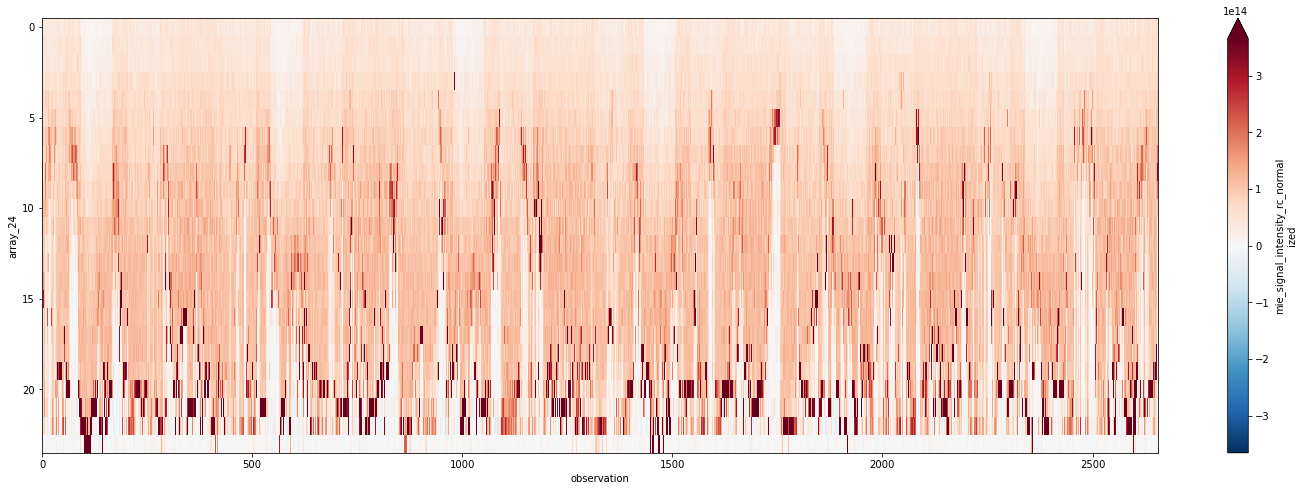

In [163]:
plt.rcParams["figure.figsize"] = (25,8)
ds_observations["mie_signal_intensity_rc_normalized"].plot.pcolormesh(
    x="observation",
    yincrease=False,
    robust=True
)

<ipython-input-162-ec5deed8e95d>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(ds_observations["datetime"],


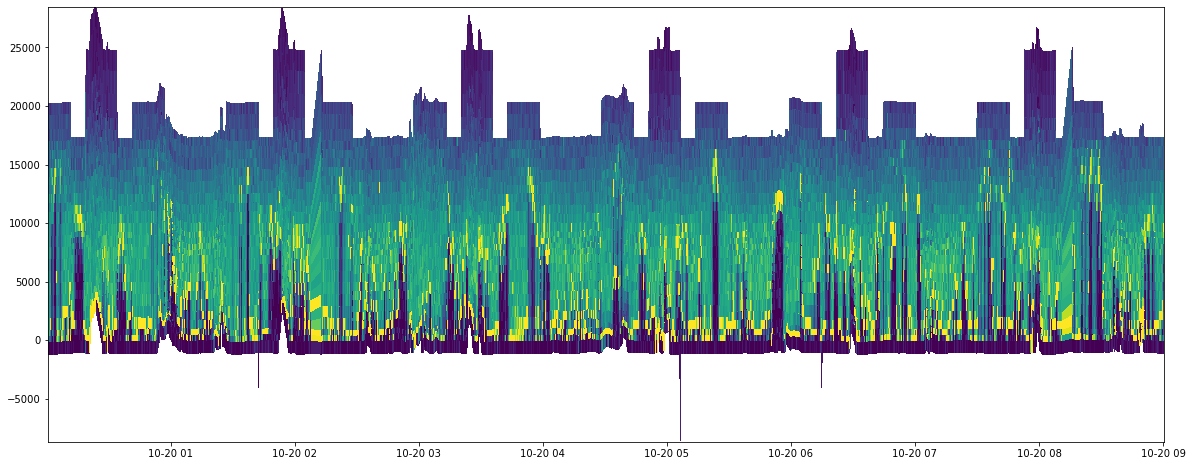

In [162]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.pcolormesh(ds_observations["datetime"],
              ds_observations["mie_altitude"].T,
              ds_observations["mie_signal_intensity_rc_normalized"].T,
             vmin=np.percentile(ds_observations["mie_signal_intensity_rc_normalized"],5),
             vmax=np.percentile(ds_observations["mie_signal_intensity_rc_normalized"],95))
# plt.pcolormesh()

In [154]:
ds_observations["mie_signal_intensity_rc_normalized"].shape

(2656, 24)